# Minilab 2

<b>Class:</b> MSDS 7331 Data Mining
<br> <b>Dataset:</b> Belk Endowment Educational Attainment Data 

<h1 style="font-size:150%;"> Teammates </h1>
Maryam Shahini
<br> Murtada Shubbar
<br> Michael Toolin
<br> Steven Millett

In [1]:
#Set global variables
#Number of features we will be selecting for feature selection

N_FEATURES_OPTIONS = [25 , 50, 100, 200, 300]


#Alpha and C we will be using for our classifiers

C_OPTIONS = [1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3, 1e4]


#Import data all necessary libraries we will be using in our estimation

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#from pandas.plotting import scatter_matrix
import seaborn as sns
import math
import re
import sklearn
import statistics
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import KFold

from sklearn.decomposition import PCA, NMF
from sklearn.feature_selection import SelectKBest, chi2, SelectPercentile

from sklearn.feature_selection import RFE

from sklearn.svm import SVC, LinearSVC

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

from IPython.display import display, HTML

from sklearn.pipeline import Pipeline

from sklearn.pipeline import make_pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import Binarizer

from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import train_test_split

%matplotlib inline

In [2]:
# The 2017 Public Schools Machine Learning 
# Date Set is being used throughout this 
# analysis.  The _ML suffix is removed to less 
# name space size
# Load Full Public School Data Frames for each year

school_data = pd.read_csv('../Data/2017/Machine Learning Datasets/PublicSchools2017_ML.csv', low_memory=False)

#Checks for current version of scikit learn
#print('The scikit-learn version is {}.'.format(sklearn.__version__))

# Create Models

In [3]:
#split data into X and y dataframes

SPG_Grade_col = school_data.filter(regex=('^SPG\WGrade')).columns
y = school_data[SPG_Grade_col].apply(lambda row:'A' if row.any()!=1 else 
                                 row[0]*'A+NG'+row[1]*'B'+row[2]*'C'+row[3]*'D'+row[4]*'F'+row[5]*'I',axis=1)

#Removed SPG Grade and unit code(which is primary key for school data table)
 
X = school_data[school_data.columns.drop(list(school_data.filter(regex='^SPG\WGrade|^SPG\WScore|unit_code')))]

In [4]:
# split X and y into test and train sets. We still want
# to do this for external Cross Validation

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)

# Training of the model

Here we are training the logistic regression, SVM, and SGDClassifier models. We are using 10 k-fold internal cross validation to train and test our model. A simple pipeline was created which and then grid search was used for parameter selection. The pipeline has 3 main steps:
1. dimension reduction
2. sample scaling
3. classification

The grid search will try the following parameters for each of the 3 steps:
1. dimension reduction - None, NMF, PCA
1. a. Number of obersations - 25 , 50, 100, 200, 300
2. sample scaling - None, Standard Scaler
3. model classification - Logistic Regression, SVM, SGDClassifier
3. a. Number of options used for classifiers - 1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3, 1e4

In [5]:
# Here we establish a basic 10 k-fold internal
# Cross Validation seperation that will be used
# for training our model.

k_fold = KFold(n_splits=10,shuffle=True)

#This creates the template for the pipeline
# This creates a basic pipeline where we will 
# test for dementionality reduction, scaling,
# and classification.

pipe = Pipeline([('reduce_dim', NMF()),
                  ('scale', StandardScaler()), 
                  ('clf', LogisticRegression())])

In [6]:
# # #Don't run this unless you want to retrain the data.

# # Here we are establishing the basic testing criteria
# # for our pipeline. This will run through a number of
# # parameters for our pipeline, including type of dimensionality
# # reduction, number of features to reduce, scaling (yes/no), 
# # classification models, and parameters of the classification model.

# param_grid = [
#     {
#         'reduce_dim': [None],
#         'scale':[None,StandardScaler()],
#         'clf':[SVC(),LogisticRegression()],
#         'clf__C': C_OPTIONS
#     },
#     {
#         'reduce_dim': [None],
#         'scale':[None,StandardScaler()],
#         'clf':[SGDClassifier(tol=1e-3,max_iter=1000)],
#         'clf__alpha': C_OPTIONS
#     },
#     {
#         'reduce_dim': [NMF(), PCA()],
#         'reduce_dim__n_components': N_FEATURES_OPTIONS,
#         'scale':[None,StandardScaler()],
#         'clf':[SVC(),LogisticRegression()],
#         'clf__C': C_OPTIONS
#     },
#     {
#         'reduce_dim': [NMF(), PCA()],
#         'reduce_dim__n_components': N_FEATURES_OPTIONS,
#         'scale':[None,StandardScaler()],
#         'clf':[SGDClassifier(tol=1e-3,max_iter=1000)],
#         'clf__alpha': C_OPTIONS
#     },
#     {
#         'reduce_dim': [SelectKBest(chi2)],
#         'reduce_dim__k': N_FEATURES_OPTIONS,
#         'scale':[None,StandardScaler()],
#         'clf':[SVC(),LogisticRegression()],
#         'clf__C': C_OPTIONS
#     },
#     {
#         'reduce_dim': [SelectKBest(chi2)],
#         'reduce_dim__k': N_FEATURES_OPTIONS,
#         'scale':[None,StandardScaler()],
#         'clf':[SGDClassifier(tol=1e-3,max_iter=1000)],
#         'clf__alpha': C_OPTIONS
#     },   
# ]


# # This will test the parameter dict against our 
# # pipeline

# grid_search = GridSearchCV(pipe, param_grid=param_grid, cv=k_fold,n_jobs=-1, verbose=1 )


# # Here we are training the model, this is 
# # what takes the most amount of time to run
# grid_search.fit(X_train, y_train)


# #This saves the grid_search variable
# # to an external file so we don't have to 
# # keep running the gridsearch

# from sklearn.externals import joblib
# joblib.dump(grid_search, 'savedBestModel.pkl')

In [6]:
#Run this to load the model from the save file

from sklearn.externals import joblib
grid_search = joblib.load('savedBestModel.pkl')


# Loads all parameters run into a dict 

params = np.array(grid_search.cv_results_['params'])


# Loads all mean test scores into an array

mean_scores = np.array(grid_search.cv_results_['mean_test_score'])

,25,50,100,200,300,None
NMF,0.686285,0.712897,0.769703,0.759468,0.751791,0.863869
PCA,0.758956,0.757421,0.752815,0.761515,0.813204,0.863869
SelectKBest,0.767144,0.828045,0.838280,0.864381,0.866940,0.863869


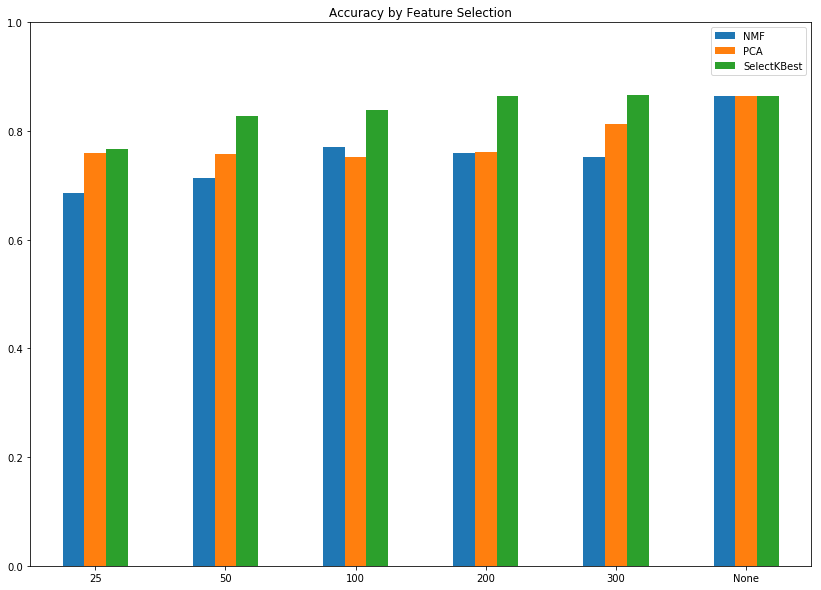

In [7]:
# Assigns all reduction models to an array

reduce_labels=['NMF','PCA','SelectKBest']


# Translates the N Features array
# to an array full of string

temp_N_FEATURES_OPTIONS = [str(r) for r in N_FEATURES_OPTIONS]
temp_N_FEATURES_OPTIONS=temp_N_FEATURES_OPTIONS+['None']


# Creates an empty dataframe that is to be
# filled with the mean test accuracy by N Features
# variable and the different feature reduction models

reduce_temp = pd.DataFrame(columns=reduce_labels,index=temp_N_FEATURES_OPTIONS,
                               data=np.linspace(.1,.25,num=len(temp_N_FEATURES_OPTIONS)*len(reduce_labels)).reshape(+len(temp_N_FEATURES_OPTIONS),len(reduce_labels)))


for i, (param, score) in enumerate(zip(params, mean_scores)):
    trigger=0
    reduce_state = str(param['reduce_dim']).split('(')[0]
    if 'reduce_dim__k' in param:
        N_FEAT = str(param['reduce_dim__k'])
        trigger=1
    elif 'reduce_dim__n_components' in param:
        N_FEAT = str(param['reduce_dim__n_components'])
        trigger=1
    else:
        if reduce_temp.at['None','NMF'] < score:
            for method in reduce_labels:
               reduce_temp.at['None',method] = score
    if trigger == 1:
        if reduce_temp.at[N_FEAT,reduce_state] < score:
            reduce_temp.at[N_FEAT,reduce_state] = score

            
# Printing a grid of the best accuracies

display(reduce_temp.transpose())


# Print a bar plot which shows the best 
# accuracies

reduce_temp.plot(kind='bar',ylim=(0,1),figsize=(14,10),title='Accuracy by Feature Selection',rot=0);           

In [8]:
#print('The Index of the best model is',grid_search.best_index_)
print('The parameters of the best model is')
display(grid_search.best_params_)
print('The accuracy of the best model is',round(grid_search.best_score_*100,4))

The parameters of the best model is


{'clf': SVC(C=10.0, cache_size=200, class_weight=None, coef0=0.0,
   decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
   max_iter=-1, probability=False, random_state=None, shrinking=True,
   tol=0.001, verbose=False),
 'clf__C': 10.0,
 'reduce_dim': SelectKBest(k=300, score_func=<function chi2 at 0x000001E24C3A47B8>),
 'reduce_dim__k': 300,
 'scale': StandardScaler(copy=True, with_mean=True, with_std=True)}

The accuracy of the best model is 86.694


# Model Advantages

Generally speaking, logistic regression models take data (X) to create a logit function that calculates the probability of Y from 0 to 1. If P=.5, then Y is categorized as 1, otherwise Y is categorized as 0. Logistic regression is sensitive to outliers, and for probabilities close .5 the model may predict incorrectly. When data is grouped close together, this creates probabilities closer to .5 and logistic regression can struggle with this type of data. Support Vector Machines (SVM) models are classifiers attempting to create a plane between two (or more) categories of data. SVM attempts to maximize the size of this plane. The data points close to the margins create the support vectors. Data points far away from the margins are not used in creating the model. This means SVM is tolerant to outliers. The width of the margins found in the training set determines how accurate the model will be on test data which can be controlled by the regularization parameter to help control overfitting. Below we discuss how these factors played out in our data set

The SVC model showed the best accuracy of the three tested, 86.69%, but not by much. Logistic Regression showed an accuracy of 83.62% as seen in table above. The code below this cell fits the model using the best parameters found during the data training for Logistic Regression and SVC. The Logistic Regression is slightly less accurate than the SVC model by only 2.6%. The Logistic Regression fits the model slightly faster than the SVC model, on the order of a few hundredths of a second. However, when needing to train large amounts of data, this slightly faster performance will scale up to saving time with only a slightly reduced accuracy.

The Logistic Regression can be prone to overfitting when a a large number of features are present like we have in our data. However, we can see that adding in a regularization parameter ('C' parameter) the accuracy does not change significantly. By choosing the right number of features, we have a good chance of not overfitting using a Logistic Regression model. We need to be aware of any outliers in the data as these has an effect on the model.

The line chart plotting the effect the 'C' parameter (chart is two cells below) has on the accuracy of the model shows a clear difference between the Stochastic Gradient Decent (SGD) model and the SVM model. This is likely caused by not having a very linearly separable model; so, we must experiment with the regularization. The more mis-classification we allow for, the better the stochastic gradient descent model's accuracy is. This is the opposite for the SVM model. The less we allow for mis-classification the better the SVM model is. We need to be aware of overfitting this model. If we use too high of a C parameter, we are fitting the model very closely to the training data and running the risk of future test data being mis-classified (overfitting). Our best fit came at C=10 using an SVC model, at this point the accuracy levels out. The Logistic Regression model is less sensitive to changing the regularization parameter, meaning our change is less significant.

In [9]:
best_score=0
ind = 0


# Figure out the index of the best 
# model based on LogisticRegression

for index, (param, score) in enumerate(zip(params, mean_scores)):
    # Uses split to get the first part of the 
    # clf dict, which is the classifier used
    class_state = str(param['clf']).split('(')[0]
    if class_state == 'LogisticRegression' and score>best_score:
        best_score=score
        ind=index

# Sets parameters to the best found with the index

pipe.set_params(**grid_search.cv_results_['params'][ind])
print('Time to run Logistic Regression model:')
%time pipe.fit(X_train,y_train)

# Predicts the prediction of the y test
y_pred = pipe.predict(X_test)

# Assigns the accuracy of the external cross validation 
accuracy = accuracy_score(y_test,y_pred)
print ('Accuracy of Logistc Regression:',accuracy)

#
# Repeat the above for SVM
#

best_score=0
ind = 0


# Figure out the index of the best model based on SVC

for index, (param, score) in enumerate(zip(params, mean_scores)):
    # Uses split to get the first part of the 
    # clf dict, which is the classifier used
    class_state = str(param['clf']).split('(')[0]
    if class_state == 'SVC' and score>best_score:
        best_score=score
        ind=index

# Sets parameters to the best found with the index

pipe.set_params(**grid_search.cv_results_['params'][ind])
print('Time to run SVC model:')
%time pipe.fit(X_train,y_train)

# Predicts the prediction of the y test
y_pred = pipe.predict(X_test)

# Assigns the accuracy of the external cross validation 
accuracy = accuracy_score(y_test,y_pred)
print ('Accuracy of SVC:',accuracy)

Time to run Logistic Regression model:
Wall time: 1.95 s
Accuracy of Logistc Regression: 0.848670756646
Time to run SVC model:
Wall time: 1.37 s
Accuracy of SVC: 0.871165644172


,0.0001,0.001,0.01,0.1,1.0,10.0,100.0,1000.0,10000.0
SVC,0.400205,0.400205,0.400205,0.719550,0.860798,0.866940,0.865916,0.865916,0.865916
LogisticRegression,0.812692,0.812692,0.833675,0.836233,0.825998,0.816786,0.804504,0.798874,0.797851
SGDClassifier,0.822927,0.823439,0.822927,0.826510,0.804504,0.567554,0.469806,0.460594,0.465200


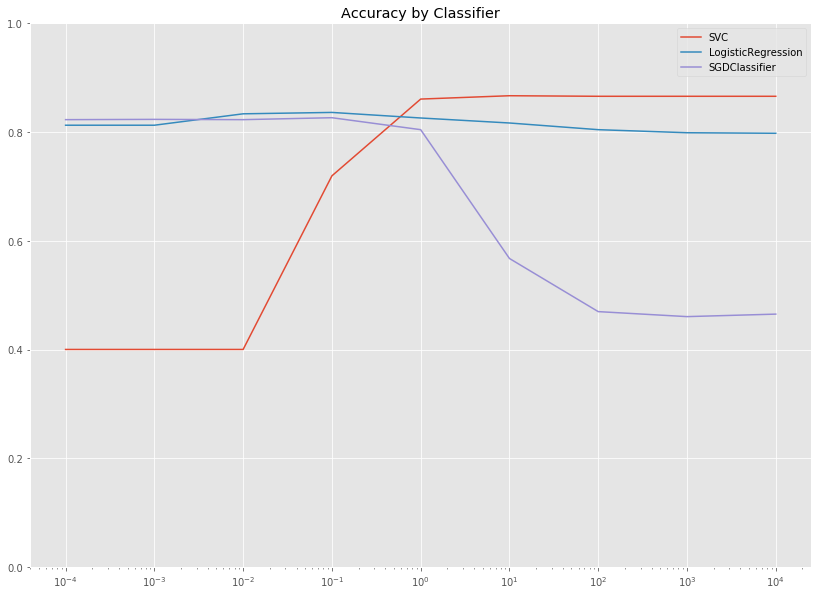

In [15]:
# Assigns all models to an array

classifier_labels=['SVC','LogisticRegression','SGDClassifier']


# Creates an empty dataframe that is to be
# filled with the mean test accuracy by C global
# variable and the different classifiers

classifier_temp = pd.DataFrame(columns=classifier_labels,index=C_OPTIONS,
                               data=np.linspace(.1,.25,num=len(C_OPTIONS)*len(classifier_labels)).reshape(len(C_OPTIONS),len(classifier_labels)))
classifier_temp.fillna(0,inplace=True)

for i, (param, score) in enumerate(zip(params, mean_scores)):
    C = param['clf__C'] if 'clf__C' in param else param['clf__alpha']
    class_state = str(param['clf']).split('(')[0]
    if classifier_temp.at[C,class_state] < score:
        classifier_temp.at[C,class_state] = score


# Printing a grid of the best accuracies
        
display(classifier_temp.transpose())   


# Print a line plot which shows the best 
# accuracies
 
classifier_temp.plot(logx=True,ylim=(0,1),figsize=(14,10),title='Accuracy by Classifier');

# Interpret Feature Importance

In [21]:
best_score=0
ind = 0


# Figure out the index of the best 
# model based on LogisticRegression

for index, (param, score) in enumerate(zip(params, mean_scores)):
    # Uses split to get the first part of the 
    # clf dict, which is the classifier used
    class_state = str(param['clf']).split('(')[0]
    if class_state == 'LogisticRegression' and score>best_score:
        best_score=score
        ind=index

# Sets parameters to the best found with
# the index

pipe.set_params(**grid_search.cv_results_['params'][ind])
pipe.fit(X_train,y_train)

#Gets the predicted coefficients for the pipeline

coef = pipe.steps[2][1].coef_

#Creates a boolean mask based on the Kbest selection
mask = pipe.steps[0][1].get_support()
new_features= []

#Creates a list of names from the columns of the original dataset
feature_names = list(X.columns.values)

for bool, feature in zip(mask, feature_names):
    if bool:
        new_features.append(feature)

#Creates a new dataframe with the coefficients and the 
predicted_data = pd.DataFrame(coef, columns=new_features)

# Predicts the prediction of the y test
y_pred = pipe.predict(X_test)

# Assigns the accuracy of the external cross validation 
accuracy = accuracy_score(y_test,y_pred)


print('The accuracy of the best Logistic Regression is',round(accuracy*100,4))
        
#Add the square of every column together to get the most influential predictors
sum1 = predicted_data.apply(lambda row: (row**2).mean(),axis=0)
#sum2 = predicted_data.apply(lambda row: abs(row).sum(),axis=0)

print("The top features that influence SPG Grade are the following")

display(sum1.sort_values(ascending=False))

The accuracy of the best Logistic Regression is 84.8671
The top 20 features that influence SPG Grade are the following


State Gap Compared_Y                                         0.546136
Math SPG Grade_C                                             0.274383
Reading SPG Grade_C                                          0.269054
Math SPG Grade_B                                             0.183703
EVAAS Growth Status_NotMet                                   0.168215
Reading SPG Grade_B                                          0.158582
Reading SPG Grade_D                                          0.132527
EOG/EOCSubjects_CACR_All                                     0.126215
Math SPG Grade_D                                             0.113580
EVAAS Growth Score                                           0.111906
EOG/EOCSubjects_CACR_EDS                                     0.102365
Math SPG Grade_F                                             0.078248
Reading SPG Grade_F                                          0.067661
pct_eds                                                      0.067063
school_type_txt_Regu

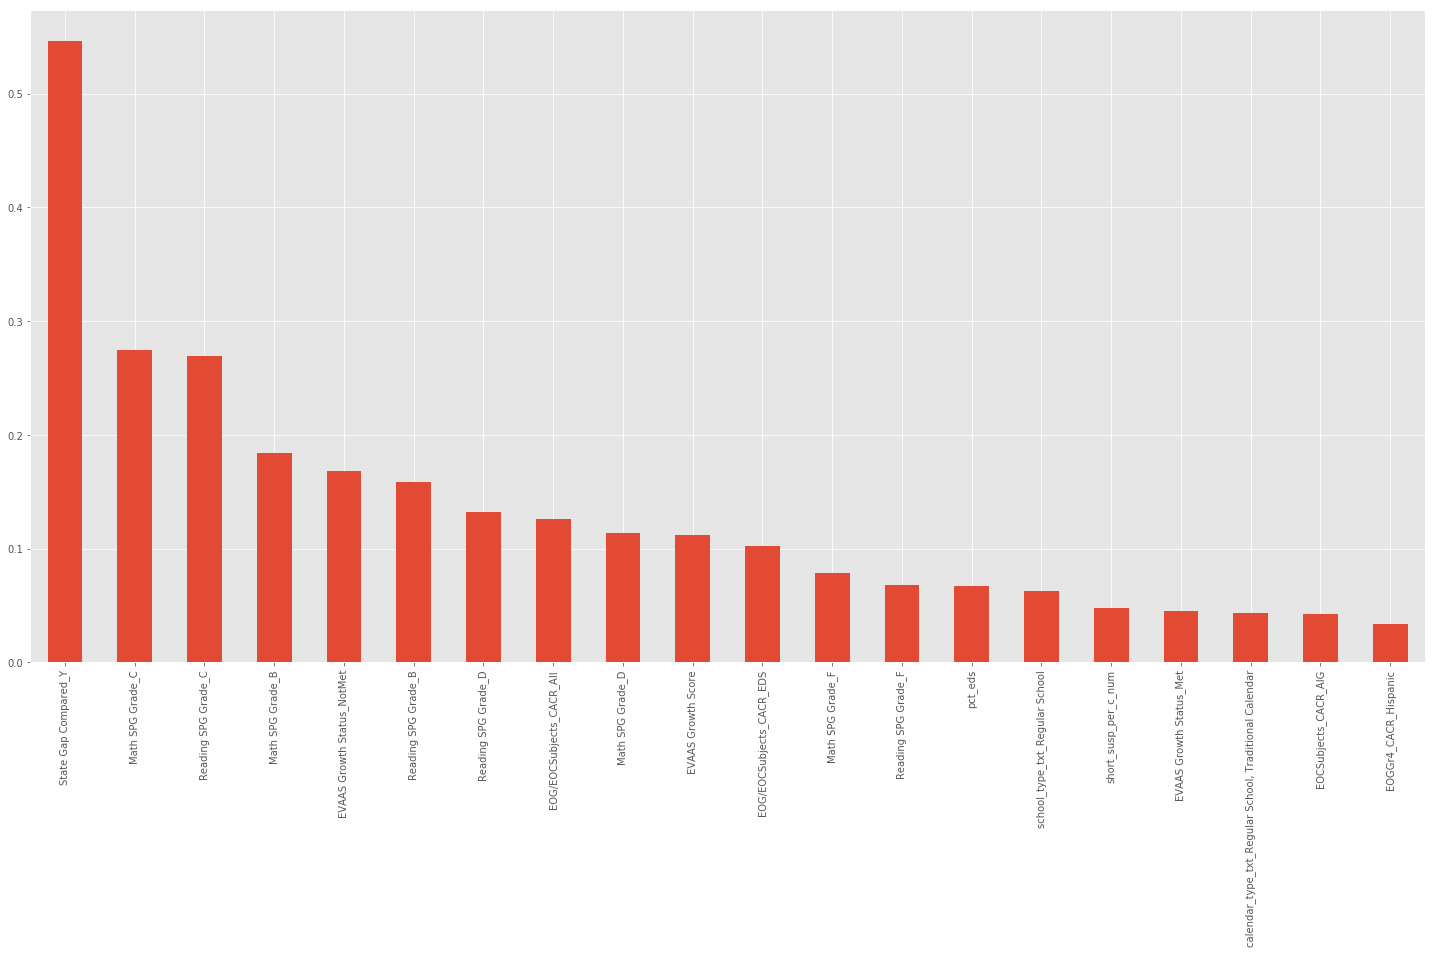

In [22]:
#Top 20 feature weights
plt.style.use('ggplot')
plt.figure(figsize = (25,12))
order = pd.Series(pd.Series(sum1))
order = order.sort_values(ascending=False)[:20]
order.plot(kind='bar')
plt.show()

The fruits of our work leads us to section, the assignment of weights to the attributes for predicting SPG Score. The North Carolina General Assembly Legislation requires assignment of School Performance Grads (SPG) beginning in 2013. After the assignment of weights is completed, we ranked the features from highest weight to lowest. We try to understand how important each features is in predicting SPG Score, but first we make sure that we have standardized the scales using StandardScaler which is a function of scikit-learn. Doing so normalized the attrubites which was orignially a big concer for us since we have a fairly large number of catagorical variables with dynamic ranges between 0 to 1. 

We made sure we're only fiting the training data which was indicated by Dr. Drew in class, and now the weights corrospond with their relevance to the response variable. 

Initial overview of the weights indicates that our best .54 for the State_Gap_Compared_Y and our least weight is .0003 for EOGReadingGr4_GLP_SWD. An immediate conclusion would be that we don't have negative weights. 

The "most important" weights for predicting SPG Score using a .1 cut-off range are: 

| Feature| Weight |
| --- | --- | 
| State Gap Compared_Y | 0.546136|
| Math SPG Grade_C | 0.274383 |
| Reading SPG Grade_C |  0.269054|
| Math SPG Grade_B  | 0.183703|
| EVAAS Growth Status_NotMet  | 0.168215|
| Reading SPG Grade_B |  0.158582 |
| Reading SPG Grade_D  | 0.132527|
| EOG/EOCSubjects_CACR_All  | 0.126215 |
| Math SPG Grade_D  | 0.113580 |
| EVAAS Growth Score  | 0.111906 |

Some of the features above look familiar because they were also identified in lab 1 as highly correlated. We start here by removing features that don't make sense to include. Primarily the possible removal of "State Gap Compared_Y" feature which does not give us any useful informantion so far. It looks like it was a derived variable and we'd need to track it down. Regardless, we're not interested in information about the state at this time. There is little information that can be found on this feature to begin with, which is a binary feature. 

The remaining features selected above are a mix of catagorical and continuous features that do logically and directly influence SPG Grade. SPG Grade is calculated using an 80% achievement measures and 20% growth measures. Schools with no growth rely on 100% achievement measures to calculate SPG grade. Two notable features are the "EVAAS Growht Status_NotMet" and "EVAAS Growth Score" which is exactly the growth measure that we factor in. EVAAS is a school accountability growht composite index score generated using end-of-grade and end-of-course assessement. This score is assigned in two different ways, either catagorically which identifies schools meeting expectations, or a converted 100 point scale composite, respectively.  

Other features such as "Math SPG Grade_C, Math SPG Grade_B, Reading SPG Grade_B, Reading SPG Grade_C" are classified under SPG achievement indicators, obviously meaning they directly factor in the calculation of the final SPG score.

We were surprised when we didn't see teacher salaries included in this list, and that will be a subject of further research in lab 2. 

# Interpret Support Vectors
Look at the chosen support vectors for the classification task. Do these provide any insight into the data? Explain. If you used stochastic gradient descent (and therefore did not explicitly solve for support vectors), try subsampling your data to train the SVC model— then analyze the support vectors from the subsampled dataset.

In [12]:
#This will search for the best logistic regression model from the previously run grid search

best_score=0
ind = 0


# Figure out the index of the best 
# model based on SVM

for index, (param, score) in enumerate(zip(params, mean_scores)):
    # Uses split to get the first part of the 
    # clf dict, which is the classifier used
    class_state = str(param['clf']).split('(')[0]
    if class_state == 'SVC' and score>best_score:
        best_score=score
        ind=index

# Sets parameters to the best found with
# the index

pipe.set_params(**grid_search.cv_results_['params'][ind])
pipe.fit(X_train,y_train)


# Predicts the prediction of the y test

y_pred = pipe.predict(X_test)

# Assigns the accuracy of the external cross validation 

accuracy = accuracy_score(y_test,y_pred)


print('The accuracy of the best SVM is',round(accuracy*100,4))
        

The accuracy of the best SVM is 87.1166
